In [1]:
pip install tensorflow==2.15.0

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os

In [3]:
# Constants
IMAGE_SIZE_1 = 225
IMAGE_SIZE_2 = 225
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
NUM_CLASSES = 27  # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/PharmaScope"

In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
# Get class names
class_names = dataset.class_names

In [6]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
# Cache, shuffle, and prefetch the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [9]:
# Build the model using DenseNet121
densenet = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)
)

In [10]:
# Freeze the DenseNet121 layers
for layer in densenet.layers:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [12]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                      

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for images_batch, labels_batch in val_ds:
            y_true.extend(labels_batch.numpy())
            preds = model.predict(images_batch)
            y_pred.extend(np.argmax(preds, axis=1))

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        logs['precision'] = precision
        logs['recall'] = recall
        logs['f1_score'] = f1_score

        print(f' - precision: {precision:.4f} - recall: {recall:.4f} - f1_score: {f1_score:.4f}')

# Add the callback to the model's fit function
metrics_callback = MetricsCallback()




In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[metrics_callback]
)

Epoch 1/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.7555 - recall: 0.7415 - f1_score: 0.7164
88/88 [==============================] - 405s 2s/step - loss: 1.9324 - accuracy: 0.5059 - val_loss: 0.9172 - val_accuracy: 0.7415 - precision: 0.7555 - recall: 0.7415 - f1_score: 0.7164
Epoch 2/50
 3/88 [>.............................] - ETA: 4s - loss: 0.9459 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 36ms/step
 - precision: 0.8172 - recall: 0.7642 - f1_score: 0.7505
88/88 [==============================] - 7s 78ms/step - loss: 0.8490 - accuracy: 0.7191 - val_loss: 0.6923 - val_accuracy: 0.7642 - precision: 0.8172 - recall: 0.7642 - f1_score: 0.7505
Epoch 3/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.8876 - recall: 0.7898 - f1_score: 0.7909
88/88 [==============================] - 7s 79ms/step - loss: 0.6115 - accuracy: 0.8029 - val_loss: 0.6215 - val_accuracy: 0.7898 - precision: 0.8876 - recall: 0.7898 - f1_score: 0.7909
Epoch 4/50
 3/88 [>.............................] - ETA: 4s - loss: 0.3816 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 35ms/step
 - precision: 0.8629 - recall: 0.8409 - f1_score: 0.8394
88/88 [==============================] - 7s 79ms/step - loss: 0.5371 - accuracy: 0.8155 - val_loss: 0.4694 - val_accuracy: 0.8409 - precision: 0.8629 - recall: 0.8409 - f1_score: 0.8394
Epoch 5/50
1/1 [==============================] - 0s 37ms/step
 - precision: 0.8873 - recall: 0.8608 - f1_score: 0.8592
88/88 [==============================] - 7s 78ms/step - loss: 0.4487 - accuracy: 0.8535 - val_loss: 0.4412 - val_accuracy: 0.8608 - precision: 0.8873 - recall: 0.8608 - f1_score: 0.8592
Epoch 6/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.8815 - recall: 0.8750 - f1_score: 0.8645
88/88 [==============================] - 7s 78ms/step - loss: 0.4008 - accuracy: 0.8664 - val_loss: 0.4238 - val_accuracy: 0.8750 - precision: 0.8815 - recall: 0.8750 - f1_score: 0.8645
Epoch 7/50
 3/88 [>.............................] - ETA: 4s - loss: 0.2424 - accuracy: 0.8958

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 36ms/step
 - precision: 0.9151 - recall: 0.8949 - f1_score: 0.8942
88/88 [==============================] - 7s 77ms/step - loss: 0.3490 - accuracy: 0.8871 - val_loss: 0.3409 - val_accuracy: 0.8949 - precision: 0.9151 - recall: 0.8949 - f1_score: 0.8942
Epoch 8/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.8805 - recall: 0.8835 - f1_score: 0.8733
88/88 [==============================] - 7s 78ms/step - loss: 0.3440 - accuracy: 0.8918 - val_loss: 0.3318 - val_accuracy: 0.8835 - precision: 0.8805 - recall: 0.8835 - f1_score: 0.8733
Epoch 9/50
 3/88 [>.............................] - ETA: 4s - loss: 0.2156 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 35ms/step
 - precision: 0.8916 - recall: 0.8892 - f1_score: 0.8813
88/88 [==============================] - 7s 78ms/step - loss: 0.3276 - accuracy: 0.8932 - val_loss: 0.3326 - val_accuracy: 0.8892 - precision: 0.8916 - recall: 0.8892 - f1_score: 0.8813
Epoch 10/50
 3/88 [>.............................] - ETA: 4s - loss: 0.4021 - accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 35ms/step
 - precision: 0.9173 - recall: 0.9062 - f1_score: 0.9017
88/88 [==============================] - 7s 78ms/step - loss: 0.3258 - accuracy: 0.8957 - val_loss: 0.2819 - val_accuracy: 0.9062 - precision: 0.9173 - recall: 0.9062 - f1_score: 0.9017
Epoch 11/50
1/1 [==============================] - 0s 38ms/step
 - precision: 0.9156 - recall: 0.8835 - f1_score: 0.8796
88/88 [==============================] - 7s 79ms/step - loss: 0.2745 - accuracy: 0.9054 - val_loss: 0.3321 - val_accuracy: 0.8835 - precision: 0.9156 - recall: 0.8835 - f1_score: 0.8796
Epoch 12/50
1/1 [==============================] - 0s 34ms/step
 - precision: 0.9275 - recall: 0.9176 - f1_score: 0.9111
88/88 [==============================] - 7s 77ms/step - loss: 0.2650 - accuracy: 0.9079 - val_loss: 0.2699 - val_accuracy: 0.9176 - precision: 0.9275 - recall: 0.9176 - f1_score: 0.9111
Epoch 13/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.9105 - reca

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 36ms/step
 - precision: 0.9192 - recall: 0.9034 - f1_score: 0.9019
88/88 [==============================] - 7s 78ms/step - loss: 0.2428 - accuracy: 0.9133 - val_loss: 0.2617 - val_accuracy: 0.9034 - precision: 0.9192 - recall: 0.9034 - f1_score: 0.9019
Epoch 16/50
1/1 [==============================] - 0s 39ms/step
 - precision: 0.9047 - recall: 0.8920 - f1_score: 0.8872
88/88 [==============================] - 7s 78ms/step - loss: 0.2135 - accuracy: 0.9237 - val_loss: 0.2966 - val_accuracy: 0.8920 - precision: 0.9047 - recall: 0.8920 - f1_score: 0.8872
Epoch 17/50
1/1 [==============================] - 0s 35ms/step
 - precision: 0.9496 - recall: 0.9375 - f1_score: 0.9368
88/88 [==============================] - 7s 78ms/step - loss: 0.2052 - accuracy: 0.9312 - val_loss: 0.1980 - val_accuracy: 0.9375 - precision: 0.9496 - recall: 0.9375 - f1_score: 0.9368
Epoch 18/50
1/1 [==============================] - 0s 36ms/step
 - precision: 0.9440 - reca

In [16]:
# Evaluate the model
scores = model.evaluate(test_ds)
print(f'Test Accuracy: {scores[1]}')

11/11 [==============================] - 177s 55ms/step - loss: 0.2519 - accuracy: 0.9091
Test Accuracy: 0.9090909361839294


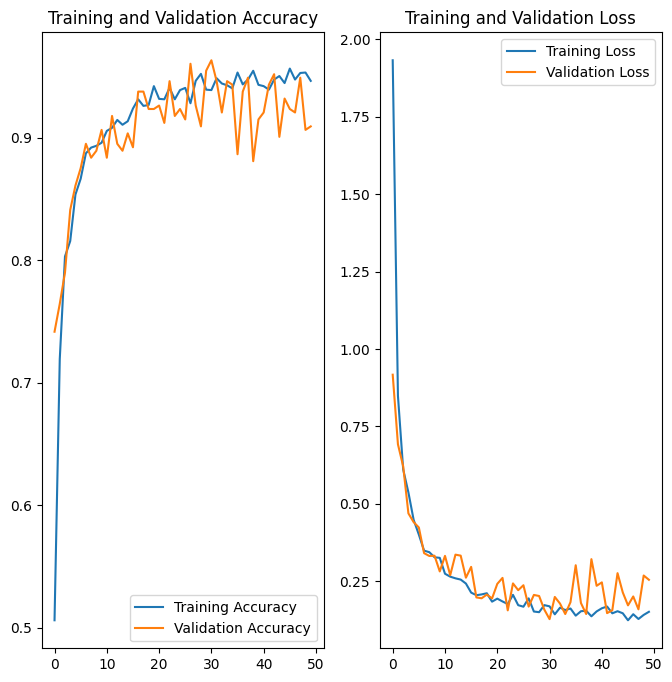

In [17]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
precision_history = history.history['precision']
recall_history = history.history['recall']
f1_score_history = history.history['f1_score']


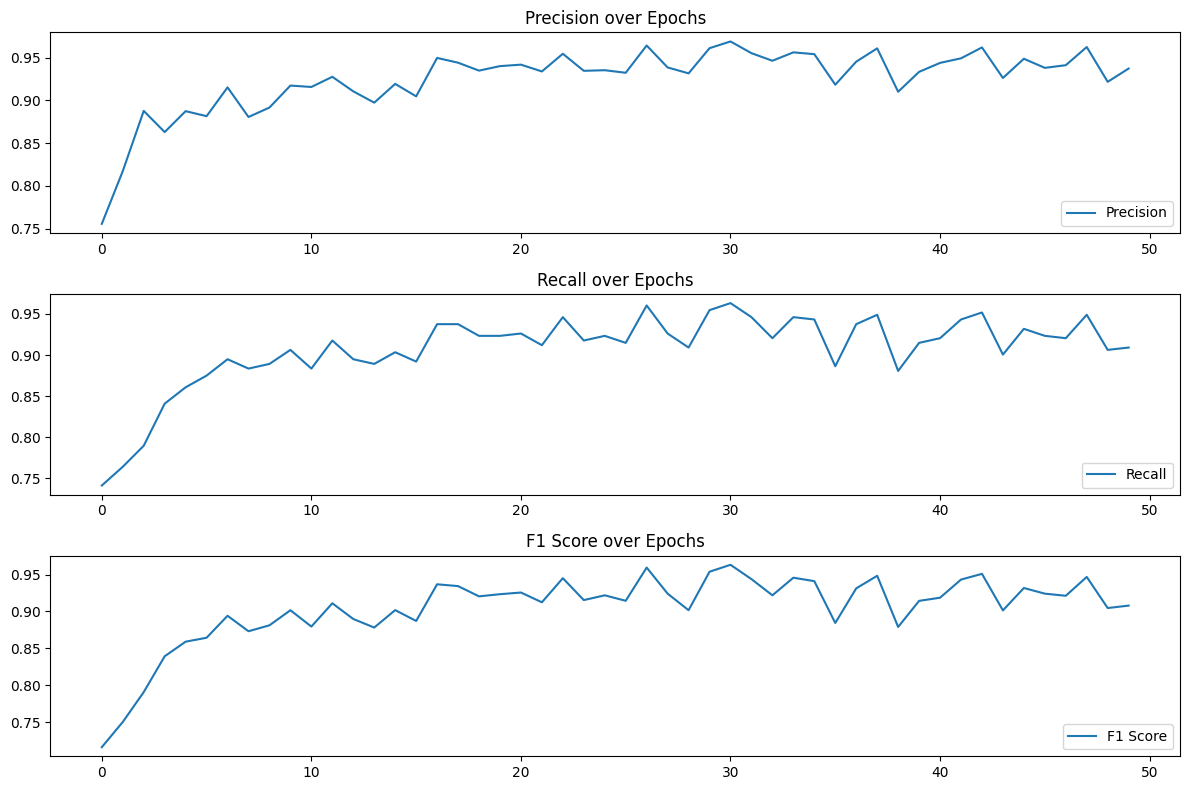

In [19]:
plt.figure(figsize=(12, 8))

# Precision
plt.subplot(3, 1, 1)
plt.plot(range(EPOCHS), precision_history, label='Precision')
plt.legend(loc='lower right')
plt.title('Precision over Epochs')

# Recall
plt.subplot(3, 1, 2)
plt.plot(range(EPOCHS), recall_history, label='Recall')
plt.legend(loc='lower right')
plt.title('Recall over Epochs')

# F1 Score
plt.subplot(3, 1, 3)
plt.plot(range(EPOCHS), f1_score_history, label='F1 Score')
plt.legend(loc='lower right')
plt.title('F1 Score over Epochs')

plt.tight_layout()
plt.show()


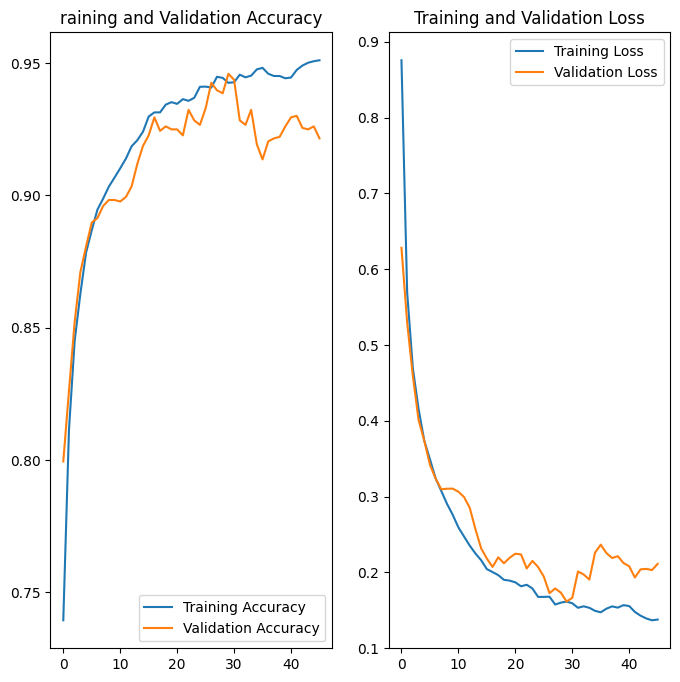

In [20]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Smooth the training and validation accuracy and loss
window_size = 5 # Adjust the window size for more or less smoothing
smooth_acc = moving_average(acc, window_size)
smooth_val_acc = moving_average(val_acc, window_size)
smooth_loss = moving_average(loss, window_size)
smooth_val_loss = moving_average(val_loss, window_size)

# Adjust the range to match the smoothed data
smooth_range = range(len(smooth_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(smooth_range, smooth_acc, label='Training Accuracy')
plt.plot(smooth_range, smooth_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('raining and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth_range, smooth_loss, label='Training Loss')
plt.plot(smooth_range, smooth_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
# Make predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    preds = model.predict(images_batch)
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 36ms/step


In [22]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 11  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  2  1  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 14

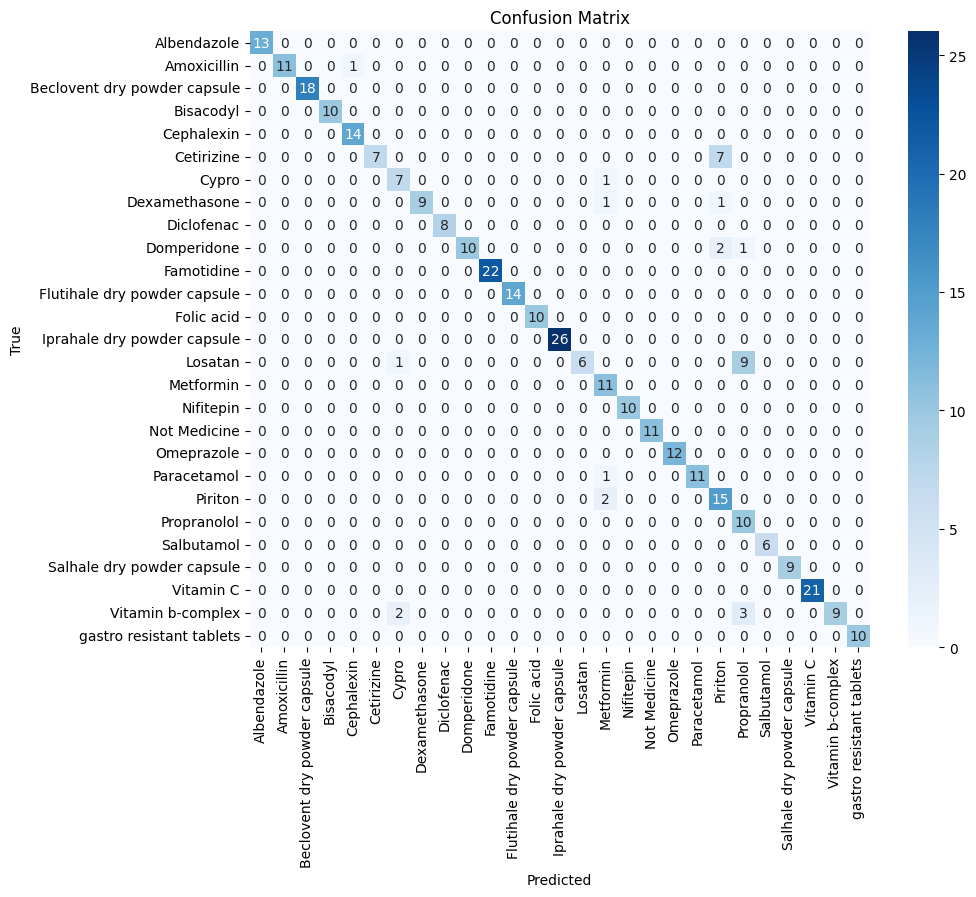

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)

Classification Report
                              precision    recall  f1-score   support

                 Albendazole       1.00      1.00      1.00        13
                 Amoxicillin       1.00      0.92      0.96        12
Beclovent dry powder capsule       1.00      1.00      1.00        18
                   Bisacodyl       1.00      1.00      1.00        10
                  Cephalexin       0.93      1.00      0.97        14
                  Cetirizine       1.00      0.50      0.67        14
                       Cypro       0.70      0.88      0.78         8
               Dexamethasone       1.00      0.82      0.90        11
                  Diclofenac       1.00      1.00      1.00         8
                 Domperidone       1.00      0.77      0.87        13
                  Famotidine       1.00      1.00      1.00        22
Flutihale dry powder capsule       1.00      1.00      1.00        14
                  Folic acid       1.00      1.00      1.00        

In [25]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

Precision: 0.9453891839591567
Recall: 0.9090909090909091
F1 Score: 0.9093292248094108
Accuracy: 0.9090909090909091


In [26]:

model.save(f"/content/drive/MyDrive/CorrectOnes/DenseNet121c.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
